https://atlantico.my.trailhead.com/pt-BR/content/bootcamp_computacao_cognitiva/modules/visao__computacional/open__cv

#Dependencies

In [3]:
!pip install opencv-python
!pip install mahotas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import data, color
from skimage.filters import threshold_otsu
import mahotas
import argparse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 4.0 MB/s 


#Functions used

In [212]:

def display_img(image,title='Image',x_label=None,y_label=None,cmap_type='gray',show_axis=False,colorBar=False,F_size=(8,6)):
  plt.figure(figsize=F_size)
  plt.imshow(image,cmap=cmap_type)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  if colorBar: plt.colorbar()
  if not show_axis: plt.axis('off')
  plt.show()


def display_multi_img(images,rows,columns,F_size=(15,8),title=None,show_axis=False):
  
  fig = plt.figure(figsize=F_size)
  #fig,ax=plt.subplots(figsize=(8,10))
  for i in range(rows):
    for j in range(columns):
      fig.add_subplot(rows,columns,i*columns+j+1)
      plt.imshow(images[i][j])
      plt.axis('off')


#Loading the image

The following images will be examples to test the algorithms and pipelines. Be aware of these variable names, their respective images, and blurred and gray versions.

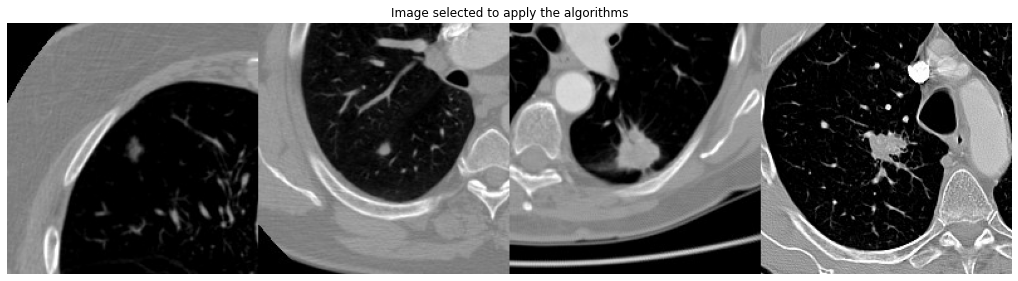

In [248]:

tumor_picture = plt.imread("nodulo2.jpg")

tumor_picture_gray = cv2.cvtColor(tumor_picture, cv2.COLOR_BGR2GRAY)  
tumor_picture_gray_blur = cv2.GaussianBlur(tumor_picture_gray, (21, 21), 0)

tumor_picture_2 = plt.imread("maligno2.jpg")

tumor_picture_2_gray = cv2.cvtColor(tumor_picture_2, cv2.COLOR_BGR2GRAY)  
tumor_picture_2_gray_blur = cv2.GaussianBlur(tumor_picture_2_gray, (21, 21), 0)

tumor_picture_3 = plt.imread("maligno3.jpg")

tumor_picture_gray = cv2.cvtColor(tumor_picture, cv2.COLOR_BGR2GRAY)  
tumor_picture_gray_blur = cv2.GaussianBlur(tumor_picture_gray, (21, 21), 0)

tumor_picture_4 = plt.imread("maligno4.jpg")

tumor_picture_4_gray = cv2.cvtColor(tumor_picture, cv2.COLOR_BGR2GRAY)  
tumor_picture_4_gray_blur = cv2.GaussianBlur(tumor_picture_4_gray, (21, 21), 0)
 
all_images = np.hstack([ np.hstack([tumor_picture,tumor_picture_2]), np.hstack([tumor_picture_3,tumor_picture_4]) ])
display_img(all_images,F_size=(18,15),title='Image selected to apply the algorithms')

##Threshold by using Otsu and Riddler-Calvard


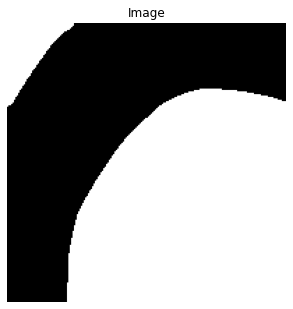

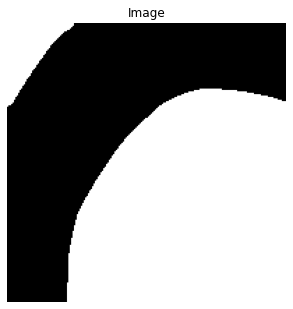

In [36]:

#tumor_picture_gray_blur = cv2.GaussianBlur(tumor_picture_gray, (21, 21), 0)

T = mahotas.thresholding.rc(tumor_picture_gray_blur)
temp = tumor_picture_gray_blur.copy() 
temp[temp > T] = 255 
temp[temp < 255] = 0 
temp = cv2.bitwise_not(temp) 
display_img(temp,F_size=(5,10))

T = mahotas.thresholding.otsu(tumor_picture_gray_blur)
temp2 = tumor_picture_gray_blur.copy() 
temp2[temp2 > T] = 255 
temp2[temp2 < 255] = 0 
temp2 = cv2.bitwise_not(temp2) 
display_img(temp2,F_size=(5,10))


#result = np.vstack([tem2,temp3])


# Blur + Fixed threshold + Sobel

The threshold value may be different for each image. As the nodule is more transparent, the threshold value must be less in order to be caught by the algorithm.

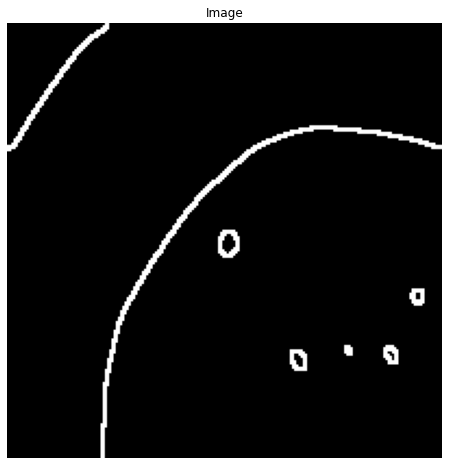

In [249]:
threshold = 50

tumor_picture_gray_threshold_blur = cv2.threshold(tumor_picture_gray_blur, threshold, 255, cv2.THRESH_BINARY_INV)[1]

sobelX = cv2.Sobel(tumor_picture_gray_threshold_blur, cv2.CV_64F, 1, 0) 
sobelX = np.uint8(np.absolute(sobelX))
sobelY = cv2.Sobel(tumor_picture_gray_threshold_blur, cv2.CV_64F, 0, 1)
sobelY = np.uint8(np.absolute(sobelY))
sobel = cv2.bitwise_or(sobelX, sobelY)

display_img(sobel,F_size=(12,8))

# Blur + Multi threshold + Sobel

#Selecting the proper threshold

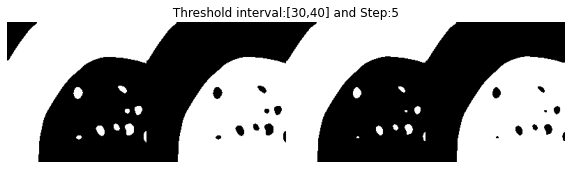

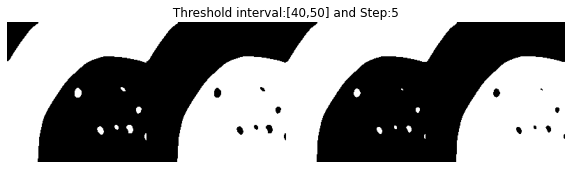

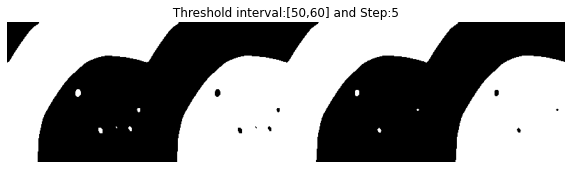

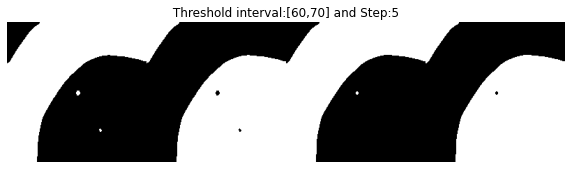

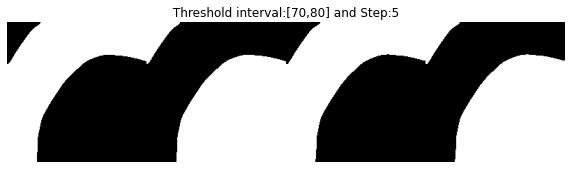

In [49]:
matrix_of_thresholds = []
qtd_columns = 4
qtd_columns = int(qtd_columns/2)
[initial_thresholds,final_thresholds] = [30,80] # set here the initial and final thresholds.
step = 5 # Step means the difference between the actual threshold and the next or prior one.
thresholds = initial_thresholds

while(True):
  
  row = []
  for index in range(qtd_columns):
    row.append(cv2.threshold(tumor_picture_gray_blur, thresholds, 255, cv2.THRESH_BINARY)[1])
    row.append(cv2.threshold(tumor_picture_gray_blur, thresholds, 255, cv2.THRESH_BINARY_INV)[1])
    thresholds+=step
  
  display_img(np.hstack(row),title=f' Threshold interval:[{thresholds-qtd_columns*step},{thresholds}] and Step:{step} ',F_size=(10,15))
  matrix_of_thresholds.append(np.hstack(row))
  if thresholds>=final_thresholds: break

result = np.vstack(matrix_of_thresholds)

#display_img(result,F_size=(18,28))

## Applying Sobel
As you can see, a threshold between 55 and 60 is a good choice. Let's try the Sobel using threshold=55.

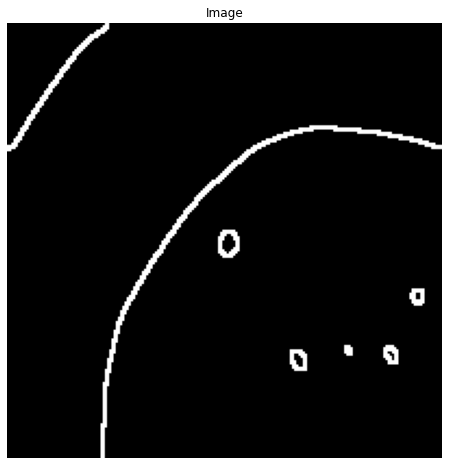

In [250]:
threshold = 50

tumor_picture_gray_threshold_blur = cv2.threshold(tumor_picture_gray_blur, threshold, 255, cv2.THRESH_BINARY_INV)[1]

sobelX = cv2.Sobel(tumor_picture_gray_threshold_blur, cv2.CV_64F, 1, 0) 
sobelX = np.uint8(np.absolute(sobelX))
sobelY = cv2.Sobel(tumor_picture_gray_threshold_blur, cv2.CV_64F, 0, 1)
sobelY = np.uint8(np.absolute(sobelY))
sobel = cv2.bitwise_or(sobelX, sobelY)

display_img(sobel,F_size=(12,8))

#Blur + Adaptative Threshold + Sobel

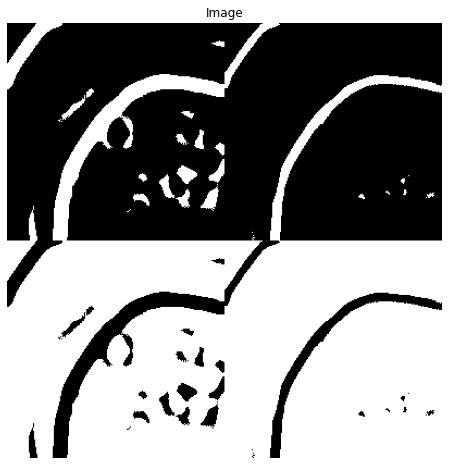

In [251]:
blocksize = 25
central_value = 7

th1 = cv2.adaptiveThreshold(tumor_picture_gray_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,blocksize,central_value)
th2 = cv2.adaptiveThreshold(tumor_picture_gray_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,blocksize,central_value)
th3 = cv2.adaptiveThreshold(tumor_picture_gray_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,blocksize,central_value)
th4 = cv2.adaptiveThreshold(tumor_picture_gray_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,blocksize,central_value)

result = np.vstack([  np.hstack([th1, th2]),  np.hstack([th3, th4])  ])   

display_img(result,F_size=(12,8))


##Blur + Fixed threshold + Sobel + connected component analysis

The following code was obtained on: https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

The variable sobel was created by applying blur, fixed threshold and sobel.

In [254]:
output = cv2.connectedComponentsWithStats(sobel, 4, cv2.CV_32S)

(numLabels, labels, stats, centroids) = output

matrix_of_slice = []
matrix_of_result = []
matrix_of_mask = []

for i in range(0,numLabels):
  
  if i is not 0:
    
    print('infor examining component {}/{}'.format(i,numLabels-1))
    x = stats[i,cv2.CC_STAT_LEFT]
    y = stats[i,cv2.CC_STAT_TOP]
    w = stats[i,cv2.CC_STAT_WIDTH]
    h = stats[i,cv2.CC_STAT_HEIGHT]
    area = stats[i,cv2.CC_STAT_AREA]
    (cX,cY) = centroids[i]
    result = tumor_picture.copy()

    image_slice = result[x:x + w+5,y:y + h+5]
    
    keepWidth = w > 5 and w < 20
    keepHeight = h > 7 and h < 20
    if all((keepWidth, keepHeight)):
      print('selected')
      matrix_of_slice.append(image_slice.copy())
      matrix_of_result.append(result)
      cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 3)
      cv2.circle(result, (int(cX), int(cY)), 4, (0, 0, 255), -1)
      componentMask = (labels == i).astype("uint8") * 255


infor examining component 1/7
infor examining component 2/7
infor examining component 3/7
selected
infor examining component 4/7
selected
infor examining component 5/7
infor examining component 6/7
selected
infor examining component 7/7
selected


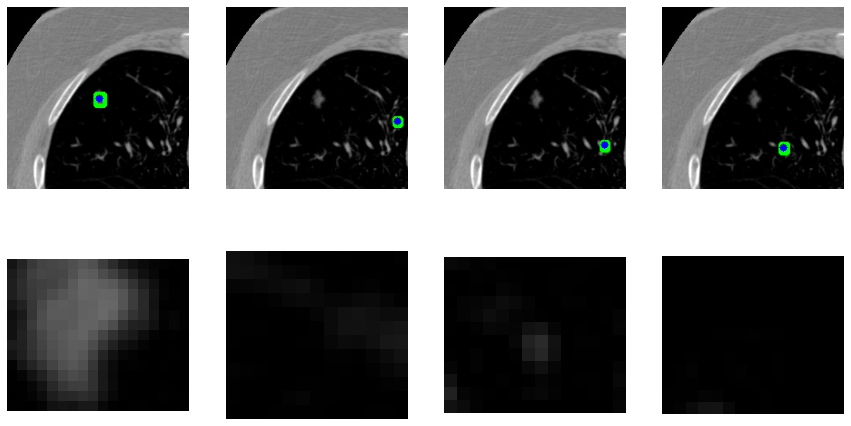

In [255]:
matrix = [matrix_of_result,matrix_of_slice]
display_multi_img(matrix,2,len(matrix_of_slice))